<a href="https://colab.research.google.com/github/zardemostoles/zardemostoles-uoc.edu/blob/master/TFG_Evaluacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga de módulos que se emplean en el notebook

In [1]:
!pip install -q aequitas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Módulos para evaluar rendimiento
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

# Módulos para evaluar equidad
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

## Definición de funciones

In [3]:
# Función para mostrar la matriz de confusión
def show_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    plt.ylabel('Diagnóstico real')
    plt.xlabel('Predicción del modelo')

    print('Verdadero negativo: ', cm[0][0])
    print('Falso positivo: ', cm[0][1])
    print('Falso negativo: ', cm[1][0])
    print('Vardadero positivo: ', cm[1][1])


## Preparación de los dataframes

In [4]:
# Fichero con las predicciones del modelo
file_predictions = "/content/drive/MyDrive/TFG/TFG_mejor_modelo_pred.csv"
# Fichero de metadatos de los/las pacientes
file_metadata = "/content/drive/MyDrive/TFG/TFG_metadatos.csv"

# Carga del fichero con las predicciones (probabilidades) del modelo
df_predictions = pd.read_csv(file_predictions)

# Carga del fichero con los metadatos de los/las pacientes
df_metadata = pd.read_csv(file_metadata)
# Se cambia el nombre de la columna del diagnóstico real 
# en el dataframe de predicciones
df_predictions.rename(columns = {'target':'target_p'}, inplace = True)

print("Número de registros en fichero de metadatos:", len(df_metadata))
print("Número de registros en fichero de predicciones del conjunto de datos de prueba:", len(df_predictions))

Número de registros en fichero de metadatos: 23257
Número de registros en fichero de predicciones del conjunto de datos de prueba: 3483


In [5]:
# Se combinan (inner join) ambos dataframes por la columna image_name
df_total = pd.merge(df_metadata, df_predictions, on='image_name')

In [6]:
# Se crea una columna con la predicción en binario
df_total['prediction_binary'] = np.where(df_total['prediction'] > 0.5, 1, 0)

In [7]:
# Se comprueba que las etiquetas del fichero de metadados 
# y del fichero de predicciones son la misma 
print(len(df_total[df_total['target']!=df_total['target_p']]))

0


In [8]:
# Se muestran los primeros registros del dataframe combinado
df_total.head(10)

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tipo_ITA,age_group_approx,target_p,prediction,prediction_binary
0,ISIC_0000001,female,30.0,anterior torso,NV,benign,0,6,"(15, 30]",0,0.014040,0
1,ISIC_0000003,male,30.0,upper extremity,NV,benign,0,1,"(15, 30]",0,0.008686,0
2,ISIC_0000009,female,30.0,anterior torso,NV,benign,0,1,"(15, 30]",0,0.000114,0
3,ISIC_0000016,female,55.0,anterior torso,NV,benign,0,6,"(45, 60]",0,0.152488,0
4,ISIC_0000072,male,85.0,posterior torso,NV,benign,0,1,"(75, 90]",0,0.791977,1
5,ISIC_0000157,male,60.0,upper extremity,MEL,malignant,1,1,"(45, 60]",1,0.935634,1
6,ISIC_0000167,male,40.0,posterior torso,MEL,malignant,1,1,"(30, 45]",1,0.999723,1
7,ISIC_0000172,female,35.0,posterior torso,MEL,malignant,1,1,"(30, 45]",1,0.964812,1
8,ISIC_0000198,male,65.0,lower extremity,NV,benign,0,2,"(60, 75]",0,0.000114,0
9,ISIC_0000199,male,20.0,upper extremity,NV,benign,0,1,"(15, 30]",0,0.002797,0


## Evaluación del rendimiento

In [9]:
# Diagnóstico real
y_true = list(df_total['target'])
# Diagnóstico predicho (probabilidad)
y_pred = list(df_total['prediction'])
# Diagnóstico predicho (binario)
y_pred_binary = list(df_total['prediction_binary'])

### Curva ROC

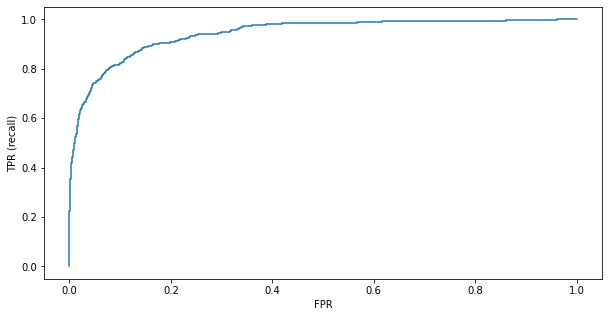

AUC: 0.943


In [10]:
# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.show()

auc = roc_auc_score(y_true, y_pred)
print("AUC: {0:.3f}".format(auc))

### Curva Precisión-Sensibilidad

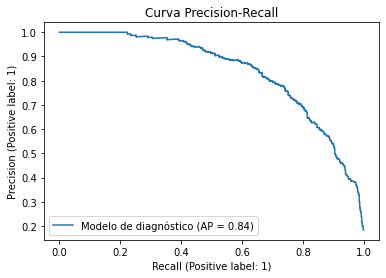

In [11]:
display = PrecisionRecallDisplay.from_predictions(y_true, y_pred, 
                                                  name="Modelo de diagnóstico");
_ = display.ax_.set_title("Curva Precision-Recall");

### Matriz de confusión

Verdadero negativo:  2722
Falso positivo:  140
Falso negativo:  160
Vardadero positivo:  461


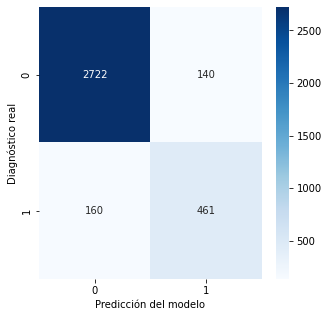

In [12]:
# Matriz de confusión
show_confusion_matrix(y_true, y_pred_binary)

In [13]:
# Métricas precisión, sensibilidad y F1
metrics = precision_recall_fscore_support(y_true, y_pred_binary)
print("Precisión:", round(metrics[0][1],2))
print("Sensibilidad:", round(metrics[1][1],2))
print("Puntuación F1:", round(metrics[2][1],2))

Precisión: 0.77
Sensibilidad: 0.74
Puntuación F1: 0.75


## Evaluación de la equidad

In [14]:
# Se crea el dataframe que se va a utilizar para la evaluación de la equidad
df_fairness = df_total.copy()
# Se necesitan tener las columnas label_value y score
df_fairness = df_fairness.rename(columns={"target": "label_value", "prediction_binary": "score"})
df_fairness["age_group_approx"] = df_fairness["age_group_approx"].astype(str)
df_fairness["tipo_ITA"] = df_fairness["tipo_ITA"].astype(str)
# Se eliminan columnas innecesarias,
df_fairness = df_fairness.drop(['image_name', 'benign_malignant', 'diagnosis', 
                          'age_approx', 'anatom_site_general_challenge',
                          'target_p',
                          'prediction'], axis=1)
df_fairness.head()

,sex,label_value,tipo_ITA,age_group_approx,score
0,female,0,6,"(15, 30]",0
1,male,0,1,"(15, 30]",0
2,female,0,1,"(15, 30]",0
3,female,0,6,"(45, 60]",0
4,male,0,1,"(75, 90]",1


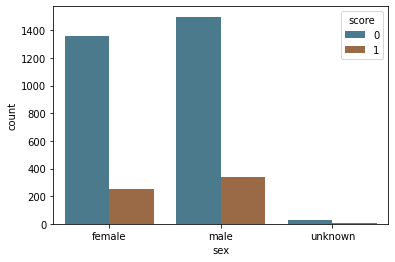

In [15]:
aq_palette = sns.diverging_palette(225, 35, n=2)
by_sex = sns.countplot(x="sex", hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

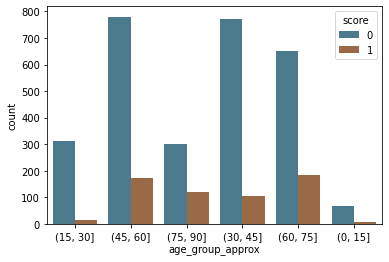

In [16]:
by_age = sns.countplot(x="age_group_approx", 
                       hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

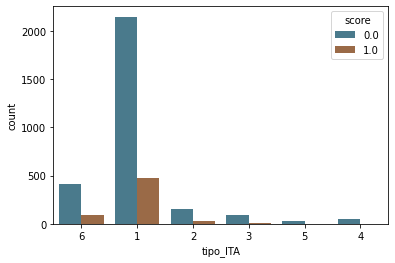

In [21]:
by_ITA = sns.countplot(x="tipo_ITA", 
                       hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

In [17]:
g = Group()
xtab, _ = g.get_crosstabs(df_fairness)

In [18]:
absolute_metrics = g.list_absolute_metrics(xtab)

#### Disparidades calculadas:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |

In [19]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,female,0.70,0.96,0.06,0.22,0.04,0.30,0.94,0.78,0.42,0.16,0.18
1,sex,male,0.78,0.95,0.05,0.24,0.05,0.22,0.95,0.76,0.57,0.19,0.18
2,sex,unknown,0.67,0.89,0.04,0.60,0.11,0.33,0.96,0.40,0.01,0.16,0.10
3,tipo_ITA,1,0.75,0.95,0.06,0.23,0.05,0.25,0.94,0.77,0.79,0.18,0.19
4,tipo_ITA,2,0.81,0.97,0.03,0.16,0.03,0.19,0.97,0.84,0.04,0.14,0.15
5,tipo_ITA,3,0.54,0.99,0.06,0.12,0.01,0.46,0.94,0.88,0.01,0.08,0.13
6,tipo_ITA,4,1.00,0.98,0.00,0.25,0.02,0.00,1.00,0.75,0.01,0.08,0.06
7,tipo_ITA,5,0.00,1.00,0.06,NaN,0.00,1.00,0.94,NaN,0.00,0.00,0.06
8,tipo_ITA,6,0.71,0.94,0.06,0.28,0.06,0.29,0.94,0.72,0.15,0.18,0.18
9,age_group_approx,"(0, 15]",0.67,0.93,0.01,0.71,0.07,0.33,0.99,0.29,0.01,0.09,0.04


In [24]:
b = Bias()
# Se toma como referencia hombres entre 30 y 50 años
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_fairness, 
                                        ref_groups_dict={'sex':'male', 
                                                         'tipo_ITA': '1',
                                                         'age_group_approx':'(30, 45]'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style

get_disparity_predefined_group()


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,601,sex,female,0.697183,0.957831,0.063328,0.220472,0.042169,0.302817,0.936672,0.779528,254,1358,0.422629,0.157568,56,86,1272,198,284,1328,1612,3483,0.176179,False,True,0.930884,male,False,1.385491,male,False,1.299534,male,False,0.784025,male,False,0.984655,male,False,0.742690,male,True,0.847736,male,True,1.021450,male,False,1.012276,male,False,0.892181,male,False
1,0,binary 0/1,601,sex,male,0.781437,0.946215,0.048732,0.236842,0.053785,0.218563,0.951268,0.763158,342,1498,0.569052,0.185870,81,73,1425,261,334,1506,1840,3483,0.181522,False,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False
2,0,binary 0/1,601,sex,unknown,0.666667,0.892857,0.038462,0.600000,0.107143,0.333333,0.961538,0.400000,5,26,0.008319,0.161290,3,1,25,2,3,28,31,3483,0.096774,False,False,2.533333,male,False,1.525114,male,False,0.789252,male,False,1.992063,male,False,1.010796,male,False,0.014620,male,False,0.867761,male,False,0.524138,male,False,0.943609,male,False,0.853129,male,False
3,0,binary 0/1,601,tipo_ITA,1,0.751540,0.948970,0.056331,0.229474,0.051030,0.248460,0.943669,0.770526,475,2148,0.790349,0.181090,109,121,2027,366,487,2136,2623,3483,0.185665,False,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False
4,0,binary 0/1,601,tipo_ITA,2,0.807692,0.973154,0.033333,0.160000,0.026846,0.192308,0.966667,0.840000,25,150,0.041597,0.142857,4,5,145,21,26,149,175,3483,0.148571,False,False,0.697248,1,False,0.773999,1,False,0.591736,1,False,0.526076,1,False,1.024371,1,False,0.052632,1,False,0.788872,1,False,1.090164,1,False,1.025485,1,False,1.074716,1,False
5,0,binary 0/1,601,tipo_ITA,3,0.538462,0.988764,0.063830,0.125000,0.011236,0.461538,0.936170,0.875000,8,94,0.013311,0.078431,1,6,88,7,13,89,102,3483,0.127451,False,True,0.544725,1,False,1.857597,1,False,1.133111,1,False,0.220183,1,False,0.992054,1,False,0.016842,1,True,0.433106,1,True,1.135587,1,False,1.041934,1,False,0.716478,1,False
6,0,binary 0/1,601,tipo_ITA,4,1.000000,0.979167,0.000000,0.250000,0.020833,0.000000,1.000000,0.750000,4,47,0.006656,0.078431,1,0,47,3,3,48,51,3483,0.058824,True,False,1.089450,1,False,0.000000,1,False,0.000000,1,False,0.408257,1,False,1.059694,1,False,0.008421,1,False,0.433106,1,False,0.973361,1,False,1.031820,1,False,1.330601,1,False
7,0,binary 0/1,601,tipo_ITA,5,0.000000,1.000000,0.060606,nan,0.000000,1.000000,0.939394,nan,0,33,0.000000,0.000000,0,2,31,0,2,31,33,3483,0.060606,False,True,nan,1,None,4.024793,1,False,1.075883,1,False,0.000000,1,None,0.995470,1,False,0.000000,1,True,0.000000,1,True,nan,1,None,1.053774,1,None,0.000000,1,False
8,0,binary 0/1,601,tipo_ITA,6,0.711111,0.938875,0.063415,0.280899,0.061125,0.288889,0.936585,0.719101,89,410,0.148087,0.178357,25,26,384,64,90,409,499,3483,0.180361,False,False,1.224101,1,False,1.162718,1,False,1.125741,1,False,1.197820,1,False,0.992494,1,False,0.187368,1,False,0.984905,1,False,0.933260,1,False,0.989362,1,False,0.946205,1,False
9,0,binary 0/1,601,age_group_approx,"(0, 15]",0.666667,0.929577,0.014

In [25]:
# Visualiza las métricas de equidad
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,sex,female,0.930884,1.385491,1.299534,0.784025,0.984655,0.742690,0.847736,1.021450,1.012276,0.892181,False,True,False,False,False,False,False,True,True,False,False,False
1,sex,male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
2,sex,unknown,2.533333,1.525114,0.789252,1.992063,1.010796,0.014620,0.867761,0.524138,0.943609,0.853129,False,False,False,False,False,False,False,False,False,False,False,False
3,tipo_ITA,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
4,tipo_ITA,2,0.697248,0.773999,0.591736,0.526076,1.024371,0.052632,0.788872,1.090164,1.025485,1.074716,False,False,False,False,False,False,False,False,False,False,False,False
5,tipo_ITA,3,0.544725,1.857597,1.133111,0.220183,0.992054,0.016842,0.433106,1.135587,1.041934,0.716478,False,True,False,False,False,False,False,True,True,False,False,False
6,tipo_ITA,4,1.089450,0.000000,0.000000,0.408257,1.059694,0.008421,0.433106,0.973361,1.031820,1.330601,True,False,False,False,False,False,False,False,False,False,False,False
7,tipo_ITA,5,nan,4.024793,1.075883,0.000000,0.995470,0.000000,0.000000,nan,1.053774,0.000000,False,True,None,False,False,None,False,True,True,None,None,False
8,tipo_ITA,6,1.224101,1.162718,1.125741,1.197820,0.992494,0.187368,0.984905,0.933260,0.989362,0.946205,False,False,False,False,False,False,False,False,False,False,False,False
9,age_group_approx,"(0, 15]",2.942857,1.036036,0.311416,2.140845,1.034663,0.067961,0.803595,0.377289,0.961196,0.982906,True,False,True,False,False,True,False,False,False,True,True,False


In [26]:
metrics = ['fpr','fdr']
disparity_tolerance = 1.25